# FEniCS overview

https://fenicsproject.org/

## Overview

- FEniCS means Finite Elements + Computational Software and 'ni' just "sits nicely in the middle"
- Finite elements solver for PDE
- Easy-to-use notation to translate scientific models into efficient code
- C++ and Python interface
- Easy installation with 
```
conda install -c conda-forge fenics
```
- Comprehensive [tutorial](https://link.springer.com/book/10.1007%2F978-3-319-52462-7) and [FEniCS book](https://fenicsproject.org/book/) are available online
- To install package for mesh generation
```
conda install -c conda-forge mshr
```
- Important! To use FEniCS inside separate environment Jupyter Notebook
```
conda create -n fenics_env python=3.6
source activate fenics_env
conda install -c conda-forge fenics
conda install notebook
conda install -c conda-forge matplotlib
conda install -c conda-forge mshr
jupyter notebook
```

## Main steps

1. Identify the computational domain $(\Omega)$, the PDE, its boundary conditions, and source terms $(f)$
2. Reformulate the PDE as a finite element variational problem
3. Write a Python program which defines the computational domain, the variational problem, the boundary conditions, and source terms, using the corresponding FEniCS abstractions
4. Call FEniCS to solve the boundary-value problem and visualize the results

### Variational form

Finite elements methods starts from *variational form* of PDE. Consider Poisson equation with Dirichlet boundary conditions
$$
\begin{align}
-\Delta u &= f(x), \quad x \in \Omega\\
u(x) &= u_D(x), \quad x \in \partial \Omega
\end{align}
$$

To get its variational form one needs:
1. Multiply both sides by test function $v$ such that $v \equiv 0$ on the boundary $\partial \Omega$
2. Intergate both sides over the domain $\Omega$ and apply integration-by-parts theorem

$$
\begin{align}
& -\int_{\Omega} \nabla^2 u \cdot v dx = \int_{\Omega} f \cdot v dx \\
& \int_{\Omega} \nabla u \cdot \nabla v dx - \underbrace{\int_{\partial \Omega} \frac{\partial u}{\partial n} v ds}_{=0} = \int_{\Omega} f \cdot v dx
\end{align}
$$
Therefore, variational form of Poisson equation with Dirichlet boundary conditions is
$$
\int_{\Omega} \nabla u \cdot \nabla v dx = \int_{\Omega} f \cdot v dx
$$
Now let's see how these form is converted to FEniCS code...

## FEniCS example
 
- Domain $\Omega = [0, 1]^2$
- $f = -6$
- $u_D = 1 + x^2 + y^2$ for $(x, y) \in \partial \Omega$

In [1]:
%matplotlib notebook
from __future__ import print_function
import fenics
import matplotlib.pyplot as plt

### Set domain and mesh

<IPython.core.display.Javascript object>


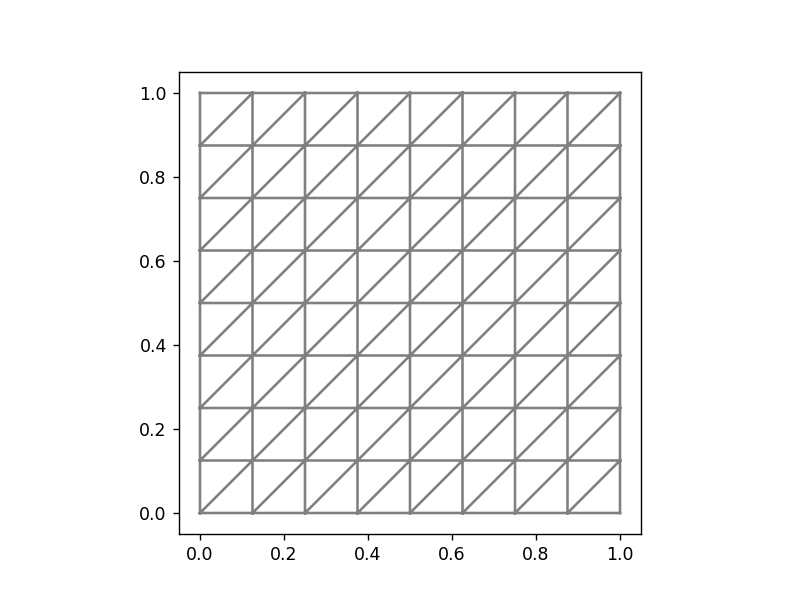

In [2]:
mesh = fenics.UnitSquareMesh(8, 8)
_ = fenics.plot(mesh)

- List of other default meshes are available [here](https://fenicsproject.org/olddocs/dolfin/1.5.0/python/demo/documented/built-in_meshes/python/documentation.html)
- Also you can create your own mesh in the following manner

<IPython.core.display.Javascript object>


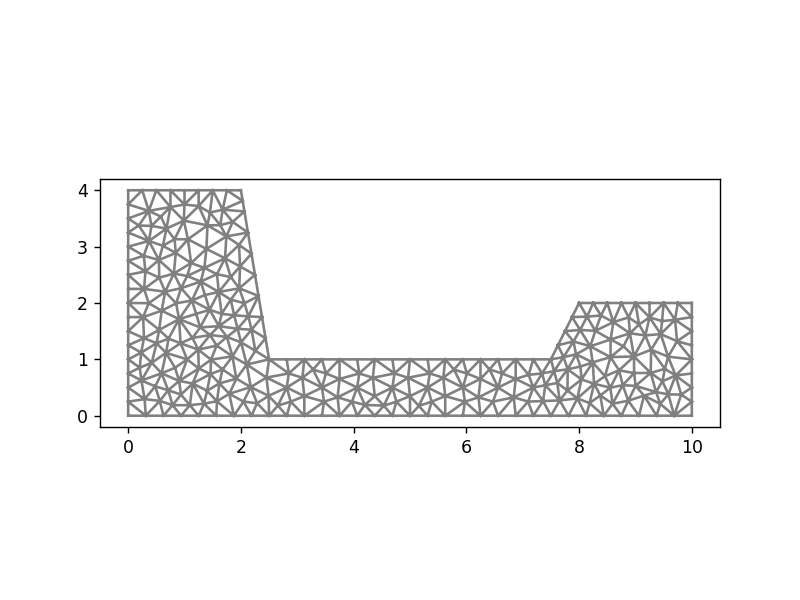

In [3]:
import dolfin
import mshr
import math

domain_vertices = [dolfin.Point(0.0, 0.0),
                   dolfin.Point(10.0, 0.0),
                   dolfin.Point(10.0, 2.0),
                   dolfin.Point(8.0, 2.0),
                   dolfin.Point(7.5, 1.0),
                   dolfin.Point(2.5, 1.0),
                   dolfin.Point(2.0, 4.0),
                   dolfin.Point(0.0, 4.0),
                   dolfin.Point(0.0, 0.0)]

p = mshr.Polygon(domain_vertices);
fenics.plot(mshr.generate_mesh(p, 20))

<IPython.core.display.Javascript object>


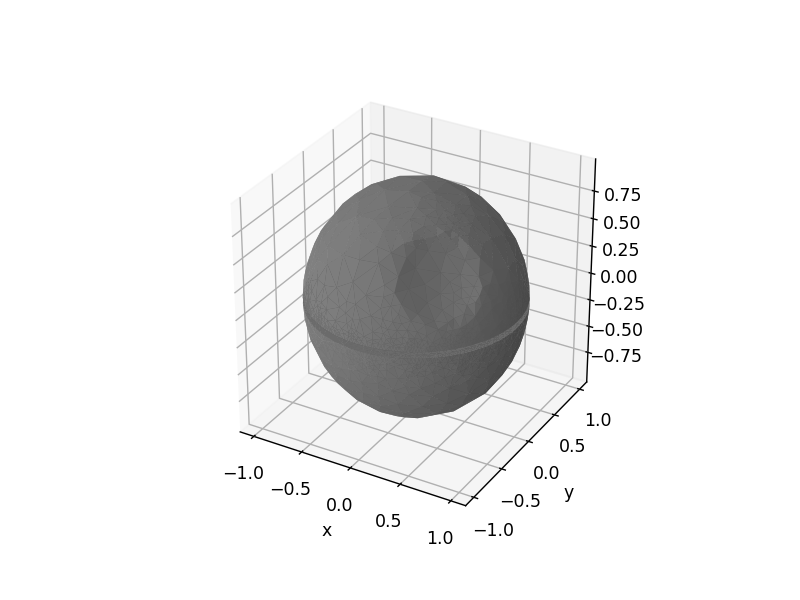

In [5]:
R = 1.1
r = 0.9
x, y, z = 1, -1, 1

# Create geometry
s1 = mshr.Sphere(dolfin.Point(0, 0, 0), 1)
s2 = mshr.Sphere(dolfin.Point(x, y, z), r)
b1 = mshr.Box(dolfin.Point(-2, -2, -0.03), dolfin.Point(2, 2, 0.03))
geometry = s1 - b1 - s2
death_star_mesh = mshr.generate_mesh(geometry, 10)

# Plot mesh
fenics.plot(death_star_mesh, color="grey")
plt.xlabel("x")
plt.ylabel("y")

### Set function space

In [6]:
V = fenics.FunctionSpace(mesh, 'P', 1)

- The first argument is a mesh
- The second argument is a family of functions that we use: "P" is a Lagrange polynomial. "DP" means discontinuous polynomial. The list of supported function spaces is available [here](https://www.femtable.org/)
- The third argument is a degree of the polynomial

### Set Dirichlet boundary conditions

In [7]:
u_D = fenics.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = fenics.DirichletBC(V, u_D, boundary)

- Function $u_D$ is written as ```Expression``` object that is directly translated into efficient C++ code
- The first argument is a string that represent mathematical equation in a valid C++ syntax
- If inside ```Expression``` some constant appeares, they should be clearly specified
```python
f = Expression("exp(-kappa*pow(pi, 2)*t)*sin(pi*k*x[0])", degree=2, kappa=1.0, t=0, k=4)
```
- The second parameter indicates the degree of function space that will be used to evaluare expression in every local element. So, the optimal value of this parameter is the same as in function space or greater by one or two
- Function ```boundary``` checks whether requested point ```x``` lies on the *Dirichlet boundary* or not. Argument ```on_boundary``` is ```True``` if requested point lies on the *physical boundary* of the mesh and ```False``` otherwise

### Set variational form

In [8]:
u = fenics.TrialFunction(V)
v = fenics.TestFunction(V)
f = fenics.Constant(-6.0)   # Or f = Expression(’-6’, degree=0)
# Left-hand side
a = fenics.dot(fenics.grad(u), fenics.grad(v))*fenics.dx
# Right-hand side
L = f*v*fenics.dx

- Function $u$ in variational form is called *trial function*
- Auxilliary function $v$ is called *test function*
- Variational forms of right- and left-hand sides are very similar to the mathematical notation
- ```dot``` is used for vectors and ```inner``` is used for matrices

### Compute solution

In [9]:
u = fenics.Function(V)
fenics.solve(a == L, u, bc)

- Redefine ```u``` from ```TrialFunction``` to solution ```Function```
- In solver we pass, variational form with sign ```==```, unknown solution and bondary conditions

<IPython.core.display.Javascript object>


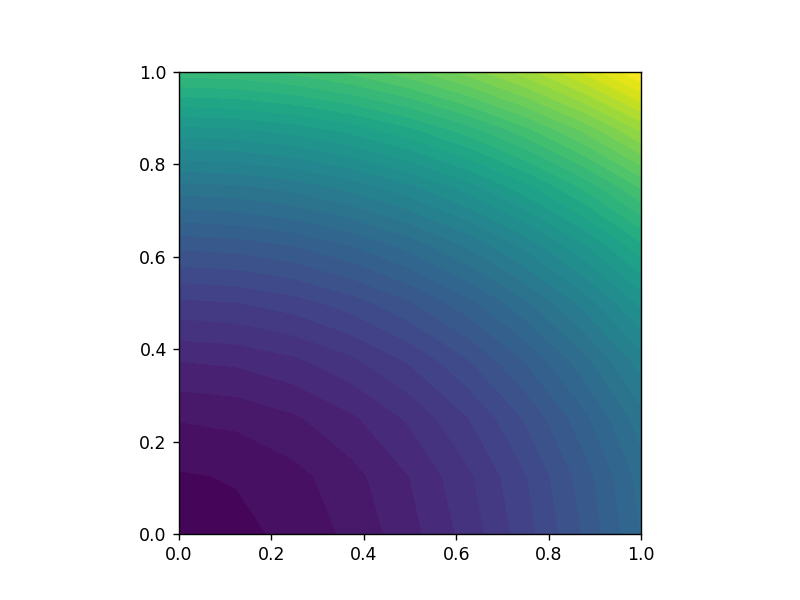

In [10]:
# Plot solution and mesh
fenics.plot(u)

### Compute error of the solution

$$
E = \sqrt{\int_{\Omega} (u - u_D)^2 dx}
$$

In [11]:
error_L2 = fenics.errornorm(u_D, u, 'L2')
print("Error in L2 norm = {}".format(error_L2))
error_H1 = fenics.errornorm(u_D, u, 'H1')
print("Error in H1 norm = {}".format(error_H1))

Error in L2 norm = 0.008235098073354806
Error in H1 norm = 0.1615842922655032


Maximum of the difference between boundary function and solution on mesh vertices:
$$
\max_{x_i \in M} |u(x_i) - u_D(x_i)|
$$

In [12]:
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
print('Error max =', error_max)

Error max = 1.33226762955e-15


<IPython.core.display.Javascript object>


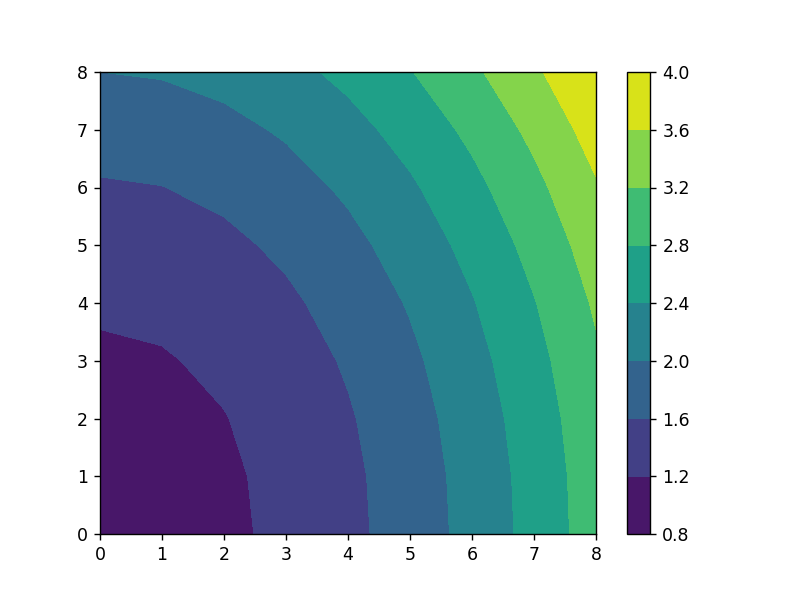

In [13]:
plt.contourf(vertex_values_u.reshape(9, 9).T)
plt.colorbar()

## Recap

- The power of variational formulation and FEniCS
- The workflow for solving PDE with FEniCS
- Dirichlet and Neumann boundary conditions are supported
- Different boundary conditions for different parts of mesh are supported
- For more examples and use cases, see tutorial and FEniCS book